In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import constraints
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

from tqdm import tqdm
import csv
import random
import math
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numbers

pyro.enable_validation(True)

In [2]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def loadCsv(filename):
    lines = csv.reader(open(filename, "r"))
    dataset = list(lines)
    for i in range(len(dataset)):
        dataset[i] = [float(x) if is_number(x) else x for x in dataset[i]]
    return dataset

filename = 'iris.csv'
dataset = loadCsv(filename)

In [3]:
def splitDataset(dataset, splitRatio):
    trainSize = int(len(dataset) * splitRatio)
    trainSet = []
    copy = list(dataset)
    while len(trainSet) < trainSize:
        index = random.randrange(len(copy))
        trainSet.append(copy.pop(index))
    return [trainSet, copy]
 
def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if (vector[-1] not in separated):
            separated[vector[-1]] = []
        separated[vector[-1]].append(vector)
    return separated
 
def mean(numbers):
    return sum(numbers)/float(len(numbers))
 
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)
 
def summarize(dataset):
    summaries = [(mean(attribute), stdev(attribute)) if isinstance(attribute[0], numbers.Number) else None 
                 for attribute in zip(*dataset)]
    print(zip(*dataset))
    del summaries[-1]
    return summaries
 
def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue] = summarize(instances)
    return summaries
 
def calculateProbability(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    gauss = (1 / (math.sqrt(2*math.pi) * stdev)) * exponent
    #print(f"x:{x}, mean:{mean}, stdev:{stdev}, gauss:{gauss}")
    return gauss
 
def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    return probabilities

def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel
 
def getPredictions(summaries, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = predict(summaries, testSet[i])
        predictions.append(result)
    return predictions
 
def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0
 
def main():
    splitRatio = 0.67
    trainingSet, testSet = splitDataset(dataset, splitRatio)
    print('Split {0} rows into train={1} and test={2} rows'.format(len(dataset), len(trainingSet), len(testSet)))
    # prepare model
    summaries = summarizeByClass(trainingSet)
    # test model
    predictions = getPredictions(summaries, testSet)
    accuracy = getAccuracy(testSet, predictions)
    print('Accuracy: {0}%'.format(accuracy))
 
main()
# mean iris accuracy .95

Split 150 rows into train=100 and test=50 rows
Accuracy: 90.0%


In [4]:
classes = [0,1,2]
attributes_count = 4

means = [5.4, 3.1, 4.8, 1.4]
stds = [2, 1, 1.75, 0.75]

# summaries=dict()
# for clazz in classes:
#     attr_summaries = []
#     for attr_idx in range(attributes_count):
#         attr_summaries.append(None)
#     summaries[clazz] = attr_summaries

# print(summaries)
    
def norm_probs(summaries, inputVector):
    #print(summaries)
    probabilities = calculateClassProbabilities(summaries, inputVector)
    #tu są nan i inf
    #print(probabilities)
    probs = torch.tensor([probabilities[0], probabilities[1], probabilities[2]])
    #print(probs)
    norm_probs = probs/torch.sum(probs)
    #print(norm_probs)
    return norm_probs

def model(x_data, y_data):
    #print("model")
    summaries=dict()
    for clazz in classes:
        attr_summaries = []
        for attr_idx in range(attributes_count):
            mean = pyro.sample(f"mean-{clazz}-{attr_idx}", pyro.distributions.Normal(3., 1.))
            std = abs(pyro.sample(f"std-{clazz}-{attr_idx}", pyro.distributions.Normal(1.5, 1.)))
            attr_summaries.append((mean,std))
        summaries[clazz] = attr_summaries
    
    lhat = torch.stack([norm_probs(summaries, x) for x in x_data])
    lhat[lhat != lhat] = 0.333 #fixme
    #print(lhat)
    with pyro.plate("generator", len(y_data)) as _:
        pyro.sample("obs", Categorical(logits=lhat), obs=y_data)
    
def guide(x_data, y_data):
    #print("guide")
    summaries=dict()
    for clazz in classes:
        attr_summaries = []
        for attr_idx in range(attributes_count):
            mean_mean_param = pyro.param(f"mean-{clazz}-{attr_idx}-mean", torch.tensor(10.))
            mean_std_param = pyro.param(f"mean-{clazz}-{attr_idx}-std", torch.tensor(5.), constraint=constraints.positive)
            mean = pyro.sample(f"mean-{clazz}-{attr_idx}", pyro.distributions.Normal(mean_mean_param, mean_std_param))
            
            std_mean_param = pyro.param(f"std-{clazz}-{attr_idx}-mean", torch.tensor(0.))
            std_std_param = pyro.param(f"std-{clazz}-{attr_idx}-std", torch.tensor(1.), constraint=constraints.positive)
            std = pyro.sample(f"std-{clazz}-{attr_idx}", pyro.distributions.Normal(std_mean_param, std_std_param))
            attr_summaries.append((mean,std))
            
        summaries[clazz] = attr_summaries
    #print("once")
    return summaries

In [5]:
def horizontal_split(data):
    if not data:
        return [[], []]
    size = len(data[0])
    attrs = [record[:size - 1] for record in data]
    classes_nested = [record[size - 1:] for record in data]
    classes = [item for sublist in classes_nested for item in sublist]
    return [attrs, classes]

x_data, y_data = horizontal_split(dataset)

In [6]:
optim = Adam({"lr": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [8]:
num_iterations = 1000
loss = 0

pyro.clear_param_store()

losses = []
for j in range(num_iterations):
    loss = svi.step(torch.tensor(x_data), torch.tensor(y_data)) #y_data.squeeze(-1)
    losses.append(loss)
    if not j % 100:
        print(loss)

902.2705383300781
175.98043704032898
194.08253061771393
182.32890039682388
188.83657544851303
151.67060482501984
148.5003422498703
205.0609189271927
160.21135371923447
214.17120623588562


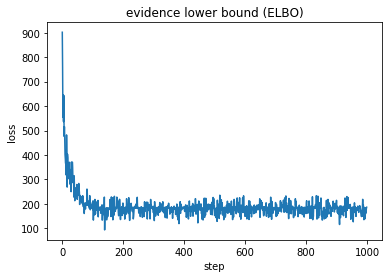

In [9]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

In [13]:
sampled_models = [guide(None, None) for _ in range(1000)]
best_model = sampled_models[0]
best_accuracy = 0
for model in sampled_models:
    predictions = getPredictions(model, testSet)
    accuracy = getAccuracy(testSet, predictions)
    
    if accuracy >= best_accuracy:
        best_model = model
        best_accuracy = accuracy
print('Accuracy: {0}%'.format(best_accuracy))

Accuracy: 86.0%


In [14]:
splitRatio = 0.67
trainingSet, testSet = splitDataset(dataset, splitRatio)
print('Split {0} rows into train={1} and test={2} rows'.format(len(dataset), len(trainingSet), len(testSet)))
predictions = getPredictions(best_model, testSet)
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: {0}%'.format(accuracy))

Accuracy: 86.0%
